<h1>Titanic Kaggle Challenge</h1>
<h5>First step: reading the data.</h5>

In [1]:
import pandas as pd

train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

<h5>Second step: dropping the unnecessary columns and transforming information into boolean.</h5>

In [2]:
import numpy as np

gender_dict = {
    'female': 1,
    'male': 0
}

train_data_v1 = train_data.drop(columns=['PassengerId', 'Name', 'Survived']).replace(gender_dict).rename(columns={'Sex': 'Woman'})
test_data_v1 = test_data.drop(columns=['PassengerId', 'Name']).replace(gender_dict).rename(columns={'Sex': 'Woman'})

train_survived_data = np.ravel(train_data['Survived'])

<h5>Third step: making the first assumptions based on the presented data.</h5>

In [3]:
cabin_nan = train_data.Cabin.isna().sum()
age_nan = train_data.Age.isna().sum()
embarked_nan = train_data.Embarked.isna().sum()
titanic_values = pd.DataFrame(train_data).shape[0]

print('The amount of NaN values encountered in the "Cabin" column represents', round(cabin_nan/titanic_values * 100, 2), '%, which is why we will consider it irrelevant,')
print('but the amount of NaN values encountered in the "Age" column represents', round(age_nan/titanic_values * 100, 2), '%, so we will treat it.')
print('Also the amount of NaN values encountered in the "Embarked" column represents', round(embarked_nan/titanic_values * 100, 2), '%, so we will treat it.')

train_data_v2 = train_data_v1.drop(columns=['Cabin'])
test_data_v2 = test_data_v1.drop(columns=['Cabin'])

The amount of NaN values encountered in the "Cabin" column represents 77.1 %, which is why we will consider it irrelevant,
but the amount of NaN values encountered in the "Age" column represents 19.87 %, so we will treat it.
Also the amount of NaN values encountered in the "Embarked" column represents 0.22 %, so we will treat it.


<h5>Fourth step: filling NaN values with mode and handling categorical string data with Label Encoding and Label Binarizer.</h5>

In [4]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

le = LabelEncoder()

aux_train_ticket = pd.DataFrame(le.fit_transform(train_data_v2.Ticket), columns=['TicketNumber'])
aux_test_ticket = pd.DataFrame(le.fit_transform(test_data_v2.Ticket), columns=['TicketNumber'])

lb = LabelBinarizer()

train_data_v3 = train_data_v2.copy()
test_data_v3 = test_data_v2.copy()
train_data_v3.Age = train_data_v2.Age.fillna(train_data_v2.Age.mode()[0])
test_data_v3.Age = test_data_v2.Age.fillna(test_data_v2.Age.mode()[0])
train_data_v3.Embarked = train_data_v2.Embarked.fillna(train_data_v2.Embarked.mode()[0])
test_data_v3.Embarked = test_data_v2.Embarked.fillna(test_data_v2.Embarked.mode()[0])

aux_train_embarked = pd.DataFrame(lb.fit_transform(train_data_v3.Embarked), columns=lb.classes_)
aux_test_embarked = pd.DataFrame(lb.fit_transform(test_data_v3.Embarked), columns=lb.classes_)

<h5>Fifth step: replacing the categorical string data for the encoded data.</h5>

In [5]:
train_data_v4 = pd.concat([train_data_v3.drop(columns=['Embarked', 'Ticket']), aux_train_ticket, aux_train_embarked], axis=1)
test_data_v4 = pd.concat([test_data_v3.drop(columns=['Embarked', 'Ticket']), aux_test_ticket, aux_test_embarked], axis=1)

<h5>Sixth step: separating the y-data from the x-data.</h5>

In [6]:
train_data_x = train_data_v4.copy()
train_data_y = train_survived_data

<h5>Seventh step: training our model.</h5>

<h5>    1. Separating the training data from the testing data:</h5>

In [7]:
from sklearn.model_selection import train_test_split

SEED = 123432
np.random.seed(SEED)

train_x, test_x, train_y, test_y = train_test_split(train_data_x, train_data_y,
                                                    test_size=0.3)

<h5>    2. Testing our model and checking its accuracy:</h5>

In [8]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=80, random_state=SEED)
rfc.fit(train_x, train_y)

accuracy = rfc.score(test_x, test_y)
print(f'A acurácia para o modelo RFC é de {round(accuracy * 100, 2)}%.')

A acurácia para o modelo RFC é de 79.48%.


In [9]:
from sklearn.model_selection import GridSearchCV

param_grid_list = list(range(20, 501, 20))
param_grid = {
    'n_estimators': param_grid_list
}
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_x, train_y)

best_n_estimators = grid_search.best_params_['n_estimators']
best_accuracy = grid_search.best_score_

print(f'The best possible accuracy for the model is {round(best_accuracy, 2) * 100}%, using {best_n_estimators} estimators.')

The best possible accuracy for the model is 86.0%, using 80 estimators.


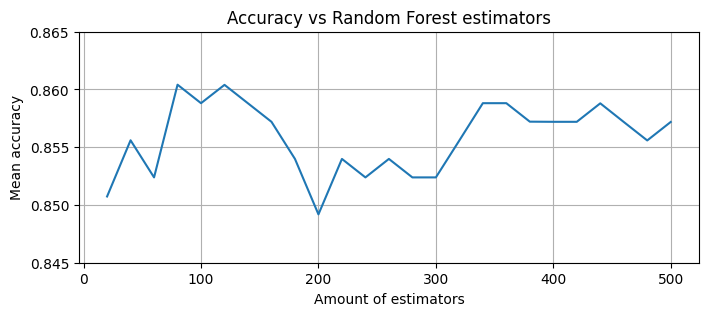

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(param_grid['n_estimators'], grid_search.cv_results_['mean_test_score'])
plt.title('Accuracy vs Random Forest estimators')
plt.ylim(0.845, 0.865)
plt.xlabel('Amount of estimators')
plt.ylabel('Mean accuracy')
plt.grid()
plt.show()

<h5>3. Comparing it with a dummy classifier:</h5>

In [11]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(train_x, train_y)

dummy_accuracy = dummy.score(test_x, test_y)
print(f'A acurácia para o modelo Dummy é de {round(dummy_accuracy * 100, 2)}%.')

A acurácia para o modelo Dummy é de 62.31%.


<h5>4. Checking our improval:</h5>

In [12]:
print(f'O modelo RFC foi {round((accuracy/dummy_accuracy - 1) * 100, 2)}% melhor que o Dummy.')

O modelo RFC foi 27.54% melhor que o Dummy.


<h5>Eighth step: generating a correlation matrix.</h5>

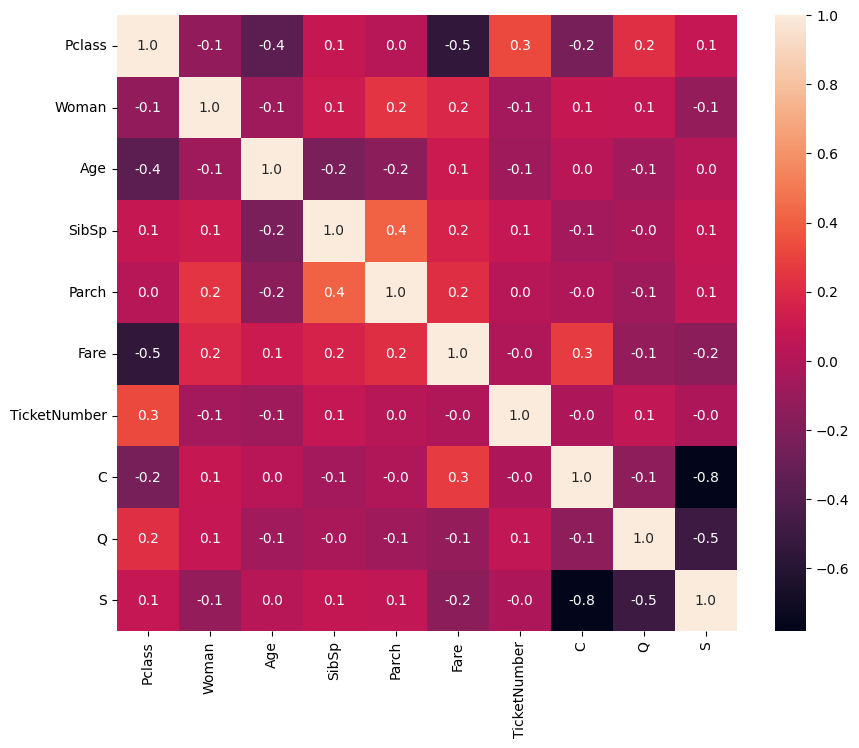

In [13]:
import seaborn as sns

correlation_matrix = train_data_v4.corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f')
plt.show()

<h5>Nineth step: since the correlation matrix showed no relevant results, let's try Select K-Features and RFECV.</h5>

In [14]:
from sklearn.feature_selection import RFECV, chi2

rfecv = RFECV(estimator=rfc, step=1, cv=5, scoring='accuracy')
rfecv.fit(train_x, train_y)
train_x_rfecv = rfecv.transform(train_x)
test_x_rfecv = rfecv.transform(test_x)

rfc.fit(train_x_rfecv, train_y)

accuracy_rfecv = rfc.score(test_x_rfecv, test_y)
print(f'A acurácia para o modelo RFC com RFECV é de {round(accuracy_rfecv * 100, 2)}%. Foram selecionadas {train_x_rfecv.shape[1]} colunas.')

A acurácia para o modelo RFC com RFECV é de 82.09%. Foram selecionadas 6 colunas.


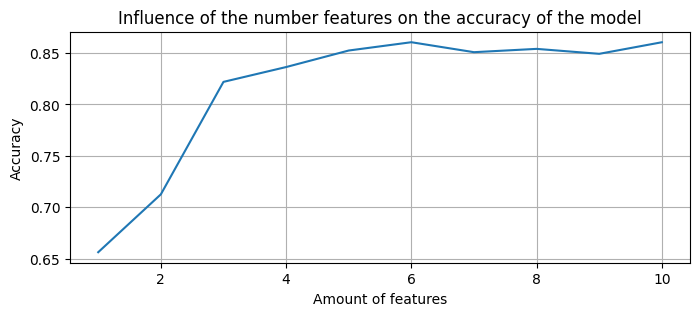

In [15]:
plt.figure(figsize=(8, 3))
plt.xlabel('Amount of features')
plt.ylabel('Accuracy')
plt.title('Influence of the number features on the accuracy of the model')
plt.grid()

plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

In [16]:
from sklearn.feature_selection import SelectKBest, chi2

select_kbest = SelectKBest(chi2, k=6)  # k = 6 como para a seleção com RFECV
select_kbest.fit(train_x, train_y)
train_x_kbest = select_kbest.transform(train_x)
test_x_kbest = select_kbest.transform(test_x)

rfc.fit(train_x_kbest, train_y)

accuracy_rfecv = rfc.score(test_x_kbest, test_y)
print(f'A acurácia para o modelo RFC com K-Best é de {round(accuracy_rfecv * 100, 2)}%.')

A acurácia para o modelo RFC com K-Best é de 80.97%.


<h5>Tenth step: checking our confusion matrix for all cases.</h5>

In [17]:
from sklearn.metrics import confusion_matrix

rfc.fit(train_x, train_y)
confusion_rfc = confusion_matrix(test_y, rfc.predict(test_x))

rfc.fit(train_x_kbest, train_y)
confusion_rfc_kbest = confusion_matrix(test_y, rfc.predict(test_x_kbest))

rfc.fit(train_x_rfecv, train_y)
confusion_rfc_rfecv = confusion_matrix(test_y, rfc.predict(test_x_rfecv))

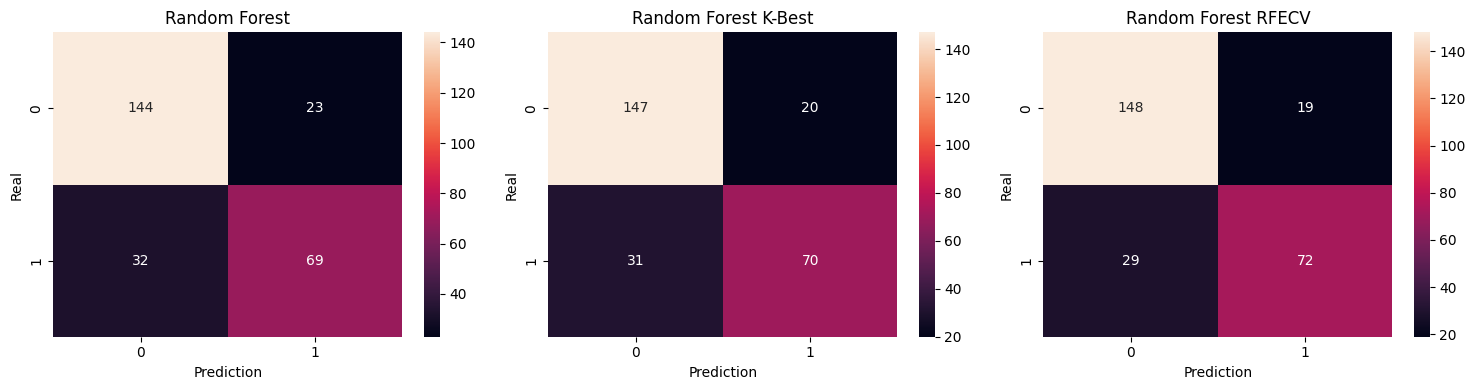

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

plt.sca(axes[0])
plt.title('Random Forest')
sns.heatmap(confusion_rfc, annot=True, fmt='d', ax=axes[0]).set(xlabel='Prediction', ylabel='Real')

plt.sca(axes[1])
plt.title('Random Forest K-Best')
sns.heatmap(confusion_rfc_kbest, annot=True, fmt='d', ax=axes[1]).set(xlabel='Prediction', ylabel='Real')

plt.sca(axes[2])
plt.title('Random Forest RFECV')
sns.heatmap(confusion_rfc_rfecv, annot=True, fmt='d', ax=axes[2]).set(xlabel='Prediction', ylabel='Real')

plt.tight_layout()
plt.show()

<h5>Eleventh step: calculating the recall and precision for each model.</h5>

In [19]:
print(f'The recall for the Random Forest model is {round(confusion_rfc[1,1]/(confusion_rfc[1,1] + confusion_rfc[1, 0]) *100, 2)}%.')
print(f'The recall for the Random Forest K-Best model is {round(confusion_rfc_kbest[1,1]/(confusion_rfc_kbest[1,1] + confusion_rfc_kbest[1, 0]) *100, 2)}%.')
print(f'The recall for the Random Forest RFECV model is {round(confusion_rfc_rfecv[1,1]/(confusion_rfc_rfecv[1,1] + confusion_rfc_rfecv[1, 0]) *100, 2)}%.')

The recall for the Random Forest model is 68.32%.
The recall for the Random Forest K-Best model is 69.31%.
The recall for the Random Forest RFECV model is 71.29%.


In [20]:
print(f'The precision for the Random Forest model is {round(confusion_rfc[1,1]/(confusion_rfc[1,1] + confusion_rfc[1, 0]) *100, 2)}%.')
print(f'The precision for the Random Forest K-Best model is {round(confusion_rfc_kbest[1,1]/(confusion_rfc_kbest[1,1] + confusion_rfc_kbest[0,1]) *100, 2)}%.')
print(f'The precision for the Random Forest RFECV model is {round(confusion_rfc_rfecv[1,1]/(confusion_rfc_rfecv[1,1] + confusion_rfc_rfecv[0,1]) *100, 2)}%.')

The precision for the Random Forest model is 68.32%.
The precision for the Random Forest K-Best model is 77.78%.
The precision for the Random Forest RFECV model is 79.12%.


<h5>Twelveth step: get the predictions from the RF RFECV model and submit it in Kaggle</h5>

In [27]:
rfc.fit(train_x_rfecv, train_y)

prediction_test_x_rfecv = rfecv.transform(test_data_v4)
predictions = rfc.predict(prediction_test_x_rfecv)

predictions_csv = pd.concat([test_data['PassengerId'], pd.DataFrame(predictions, columns=['Survived'])], axis=1)

In [31]:
predictions_csv.to_csv('titanic_kaggle.csv', index=False)